In [1]:
import pickle
import pandas as pd
pd.options.mode.chained_assignment = None
import urllib.request
import matplotlib.pyplot as plt
import os
import numpy as np

data_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"

# download data
if not os.path.isfile("data.csv"):
    urllib.request.urlretrieve(data_url, "data.csv")

"""
Use the store_object function to make local caching of the data.
"""
def store_object(filename, instruction):
    # check if file was cached before and read it
    if os.path.isfile(filename):
        return pickle.load(open(filename, 'rb'))
    # run instruction and save it as pickle then return object
    else:
        obj = instruction()
        pickle.dump(obj, open(filename, 'wb'))
        return obj

data = store_object("data.pkl", lambda: pd.read_csv("data.csv"))

# clean data

data = data[data["Vict Age"] >= 0]

# create 'DATE OCC' column to be merged DATE and TIME OCC - DATE represents the date of the incident and TIME OCC represents the time of the incident
data["DATE OCC"] = pd.to_datetime(data["DATE OCC"], format="%m/%d/%Y %I:%M:%S %p")
data["TIME OCC"] = pd.to_datetime(data["TIME OCC"].astype(str).str.zfill(4), format='%H%M')
data["DATE OCC"] = data["DATE OCC"].dt.date.astype(str) + " " + data["TIME OCC"].dt.time.astype(str)
data["DATE OCC"] = pd.to_datetime(data["DATE OCC"])

# drop 'TIME OCC' column
data = data.drop(columns=["TIME OCC"])

# drop everything after 2024/01/01 as data is incomplete
data = data[data["DATE OCC"] < "2024-01-01"]

data.head()

DR_NO               Date Rptd            DATE OCC  AREA  AREA NAME  \
0  190326475  03/01/2020 12:00:00 AM 2020-03-01 21:30:00     7   Wilshire   
1  200106753  02/09/2020 12:00:00 AM 2020-02-08 18:00:00     1    Central   
2  200320258  11/11/2020 12:00:00 AM 2020-11-04 17:00:00     3  Southwest   
3  200907217  05/10/2023 12:00:00 AM 2020-03-10 20:37:00     9   Van Nuys   
4  220614831  08/18/2022 12:00:00 AM 2020-08-17 12:00:00     6  Hollywood   

   Rpt Dist No  Part 1-2  Crm Cd                               Crm Cd Desc  \
0          784         1     510                          VEHICLE - STOLEN   
1          182         1     330                     BURGLARY FROM VEHICLE   
2          356         1     480                             BIKE - STOLEN   
3          964         1     343  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)   
4          666         2     354                         THEFT OF IDENTITY   

               Mocodes  ...  Status   Status Desc Crm Cd 1  Crm Cd 2 Crm Cd 3  \
0                  NaN  ...      AA  Adult Arrest    510.0     998.0      NaN   
1       1822 1402 0344  ...      IC   Invest Cont    330.0     998.0      NaN   
2            0344 1251  ...      IC   Invest Cont    480.0       NaN      NaN   
3            0325 1501  ...      IC   Invest Cont    343.0       NaN      NaN   
4  1822 1501 0930 2004  ...      IC   Invest Cont    354.0       NaN      NaN   

   Crm Cd 4                                  LOCATION Cross Street      LAT  \
0       NaN   1900 S  LONGWOOD                     AV          NaN  34.0375   
1       NaN   1000 S  FLOWER                       ST          NaN  34.0444   
2       NaN   1400 W  37TH                         ST          NaN  34.0210   
3       NaN  14000    RIVERSIDE                    DR          NaN  34.1576   
4       NaN                         1900    TRANSIENT          NaN  34.0944   

        LON  
0 -118.3506  
1 -118.2628  
2 -118.3002  
3 -118.4387  
4 -118.3277  

[5 rows x 27 columns]

In [2]:
from sklearn.cluster import DBSCAN

data_locations = data[["DR_NO", "LAT", "LON"]].dropna()
data_locations

DR_NO      LAT       LON
0       190326475  34.0375 -118.3506
1       200106753  34.0444 -118.2628
2       200320258  34.0210 -118.3002
3       200907217  34.1576 -118.4387
4       220614831  34.0944 -118.3277
...           ...      ...       ...
901352  231606525  34.2790 -118.4116
901353  230618716  34.0980 -118.3180
901354  230115220  34.0467 -118.2485
901355  230906458  34.1951 -118.4487
901356  230319786  34.0091 -118.3078

[874067 rows x 3 columns]

In [3]:
# drop values that are not in LA area (outside 34	-118)

data_locations = data_locations[(data_locations["LAT"] > 33) & (data_locations["LAT"] < 35)]
data_locations = data_locations[(data_locations["LON"] < -117) & (data_locations["LON"] > -119)]

In [4]:
data_locations

DR_NO      LAT       LON
0       190326475  34.0375 -118.3506
1       200106753  34.0444 -118.2628
2       200320258  34.0210 -118.3002
3       200907217  34.1576 -118.4387
4       220614831  34.0944 -118.3277
...           ...      ...       ...
901352  231606525  34.2790 -118.4116
901353  230618716  34.0980 -118.3180
901354  230115220  34.0467 -118.2485
901355  230906458  34.1951 -118.4487
901356  230319786  34.0091 -118.3078

[871804 rows x 3 columns]

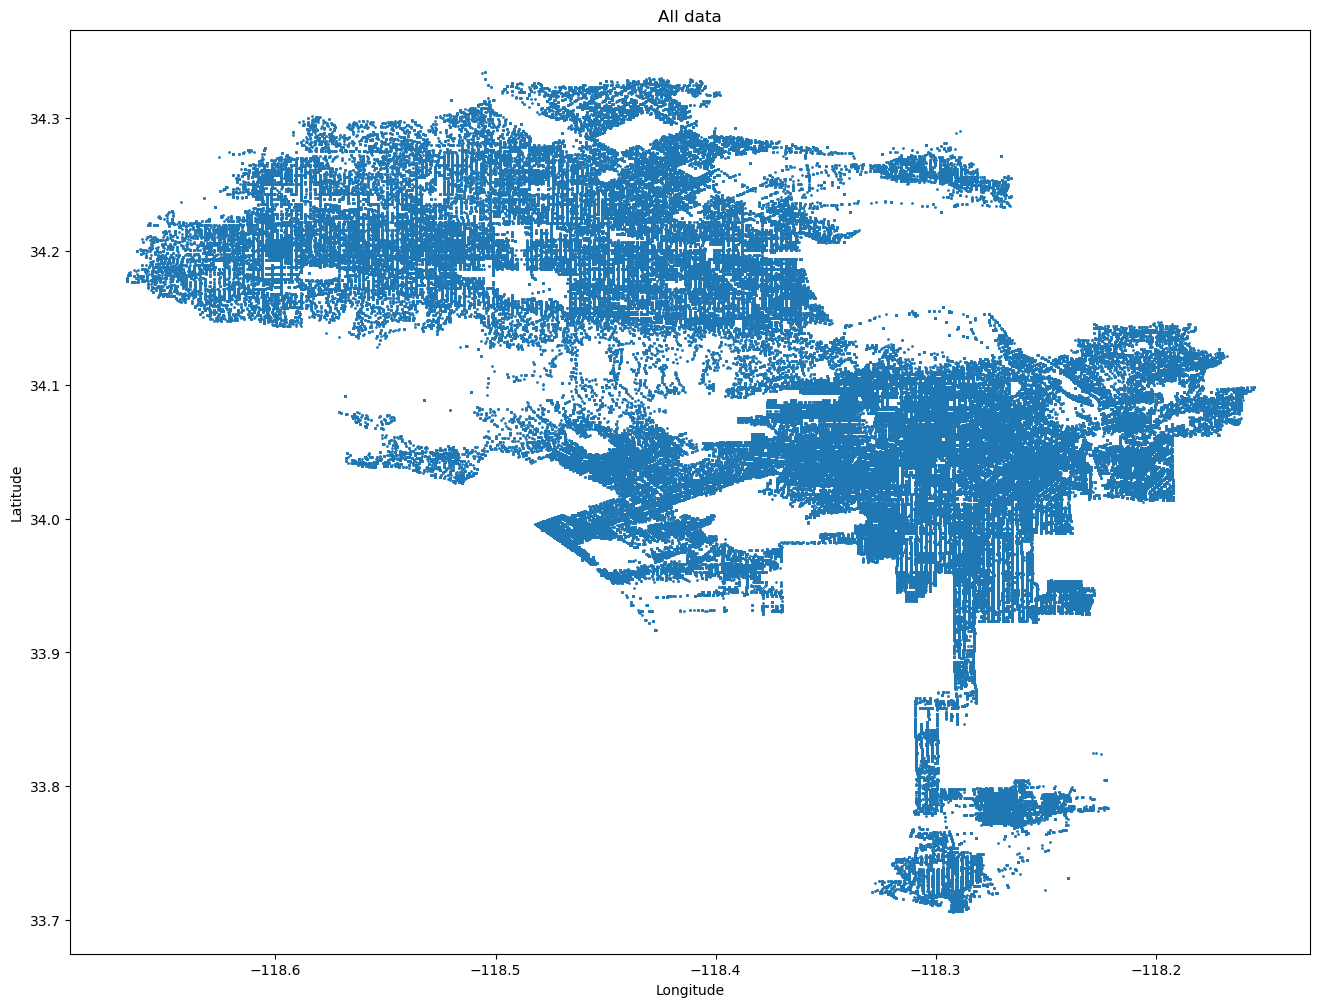

In [5]:
# plot all data

plt.figure(figsize=(16, 12))

plt.scatter(data_locations["LON"], data_locations["LAT"], s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("All data")
plt.show()


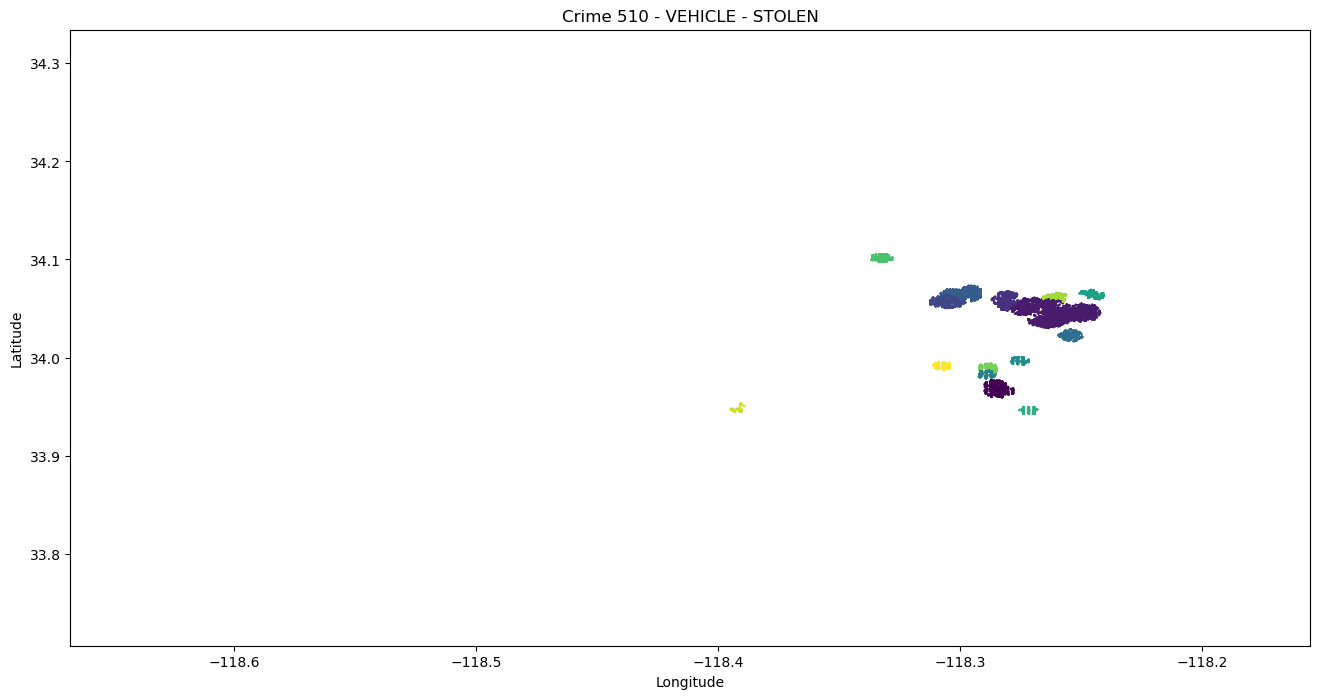

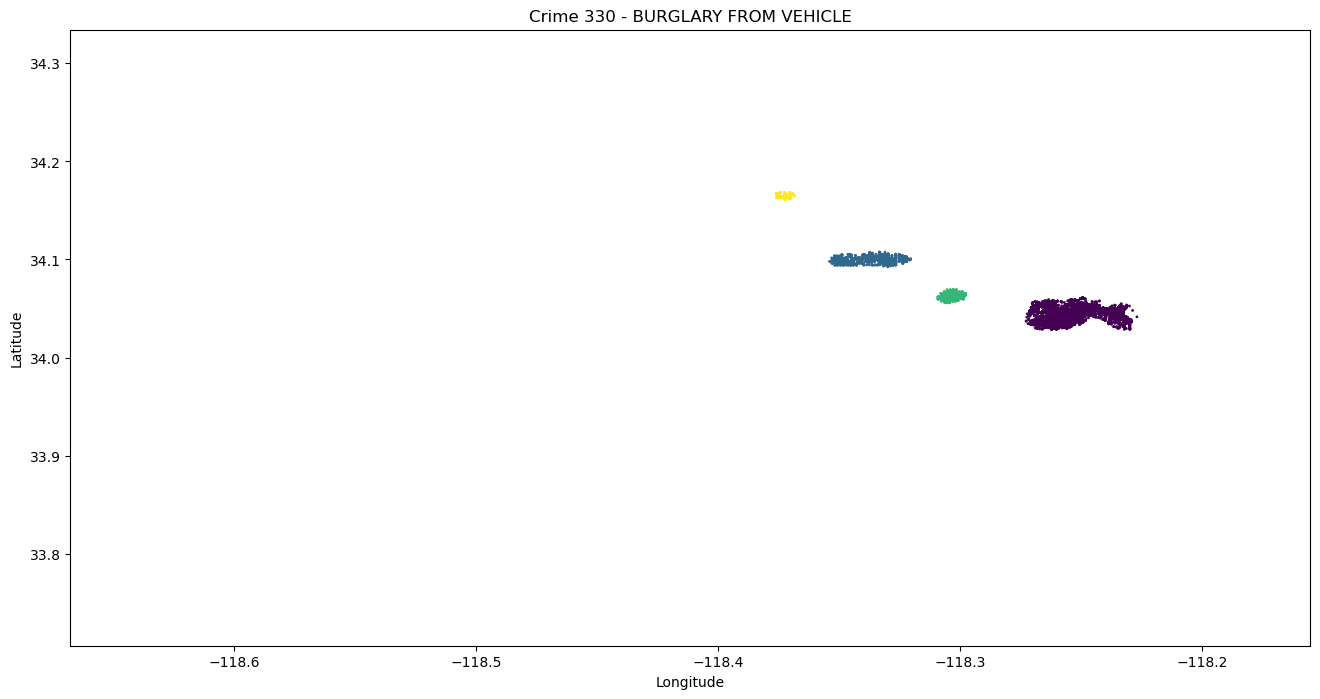

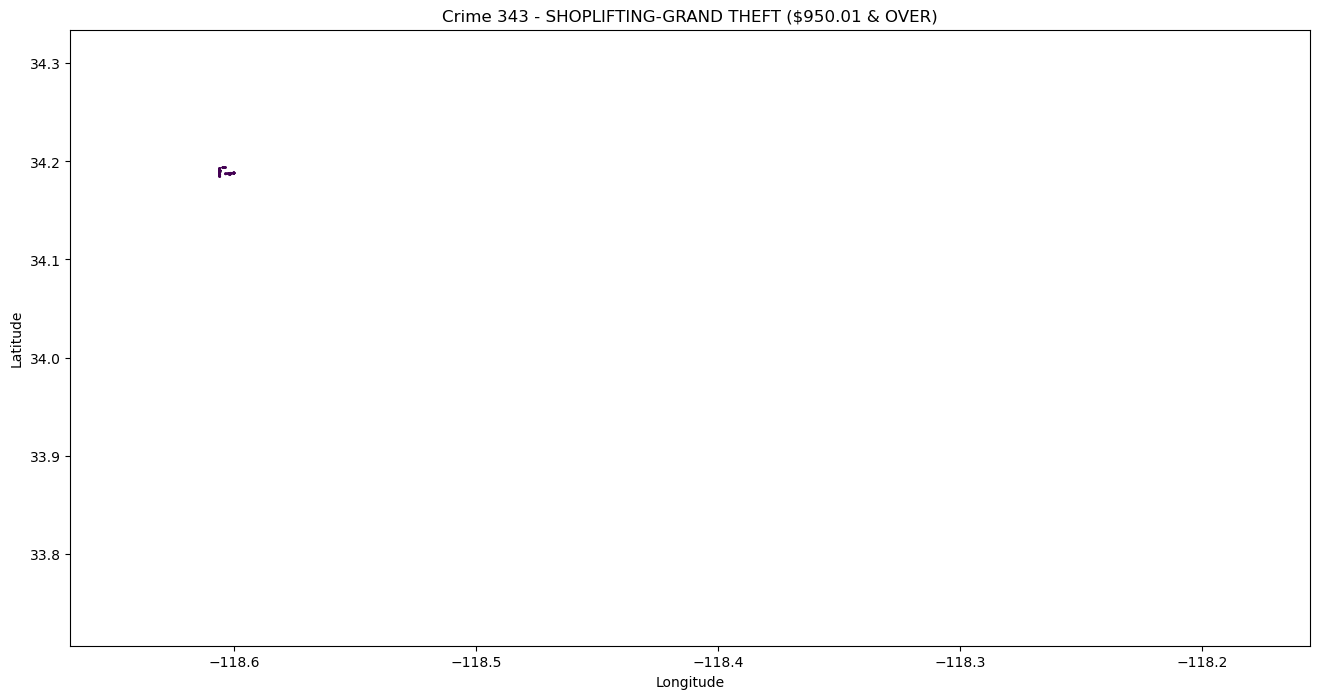

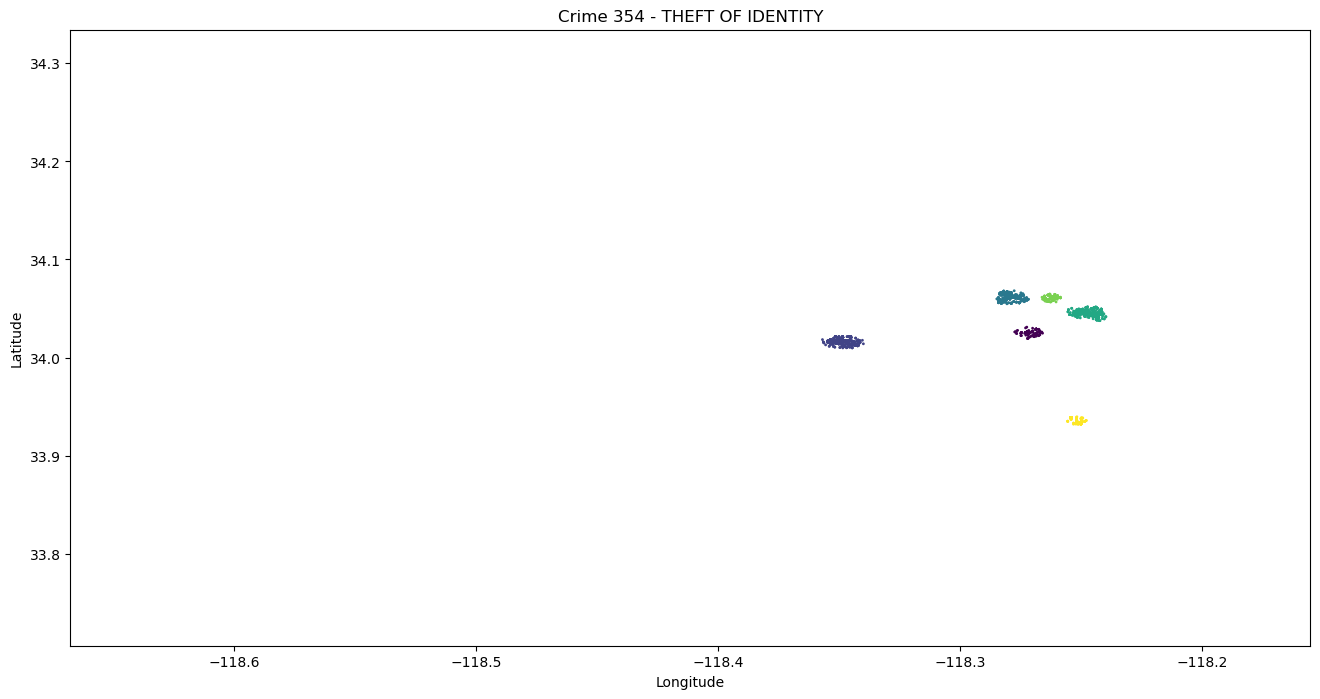

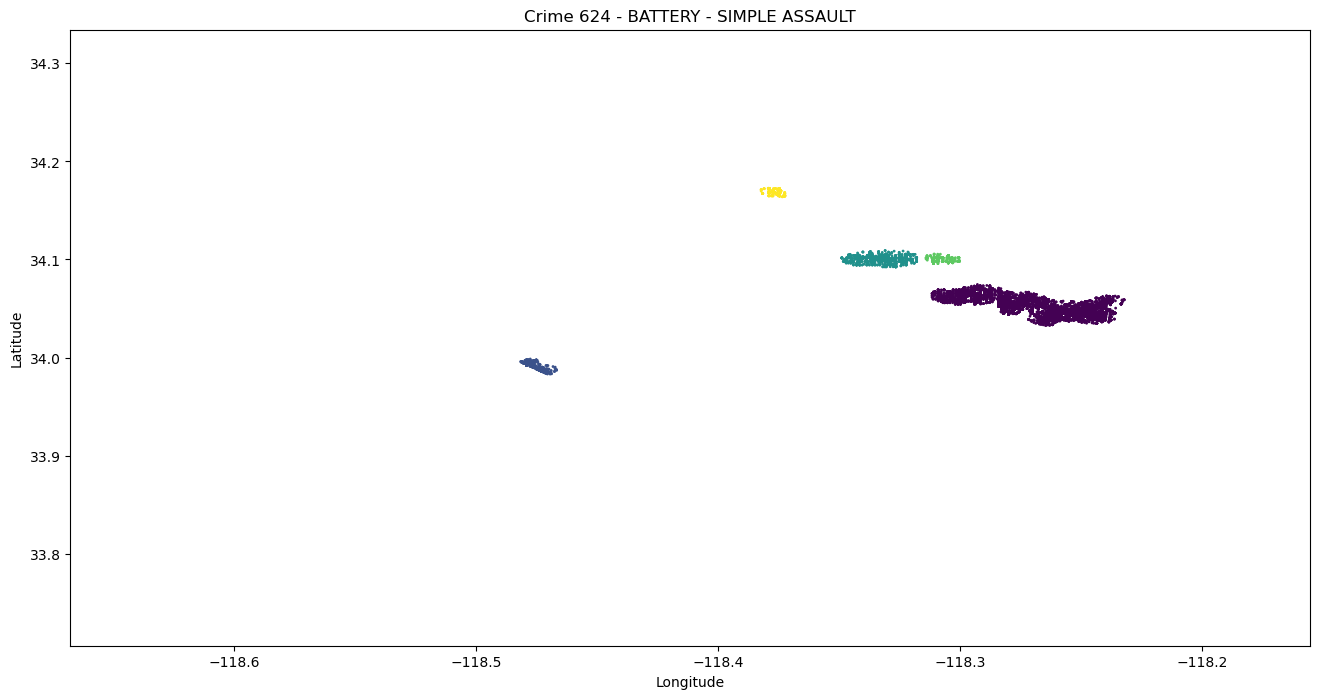

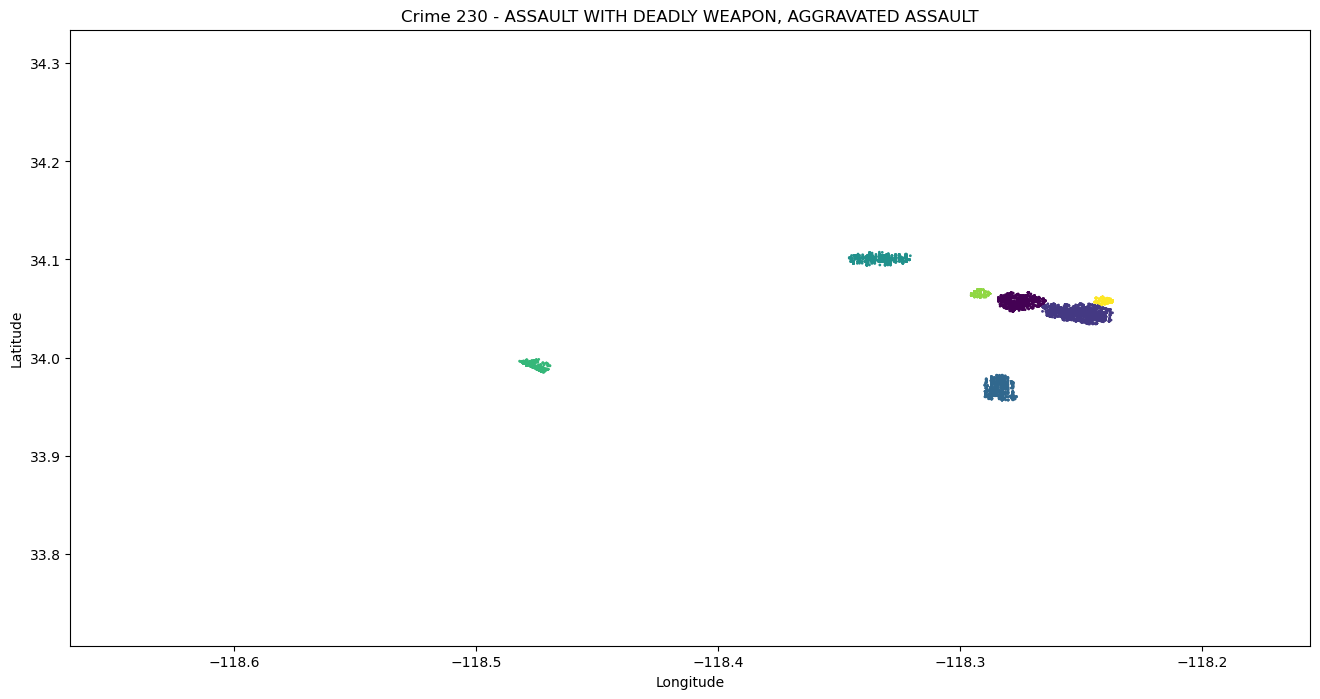

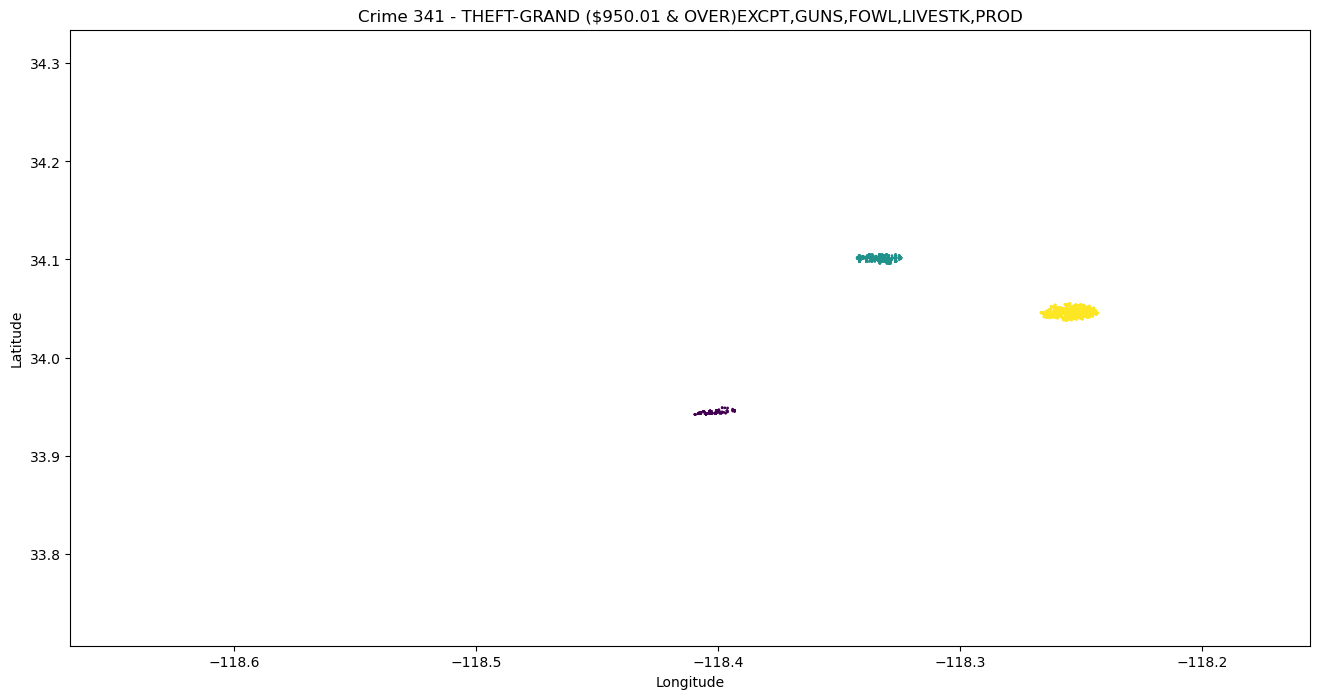

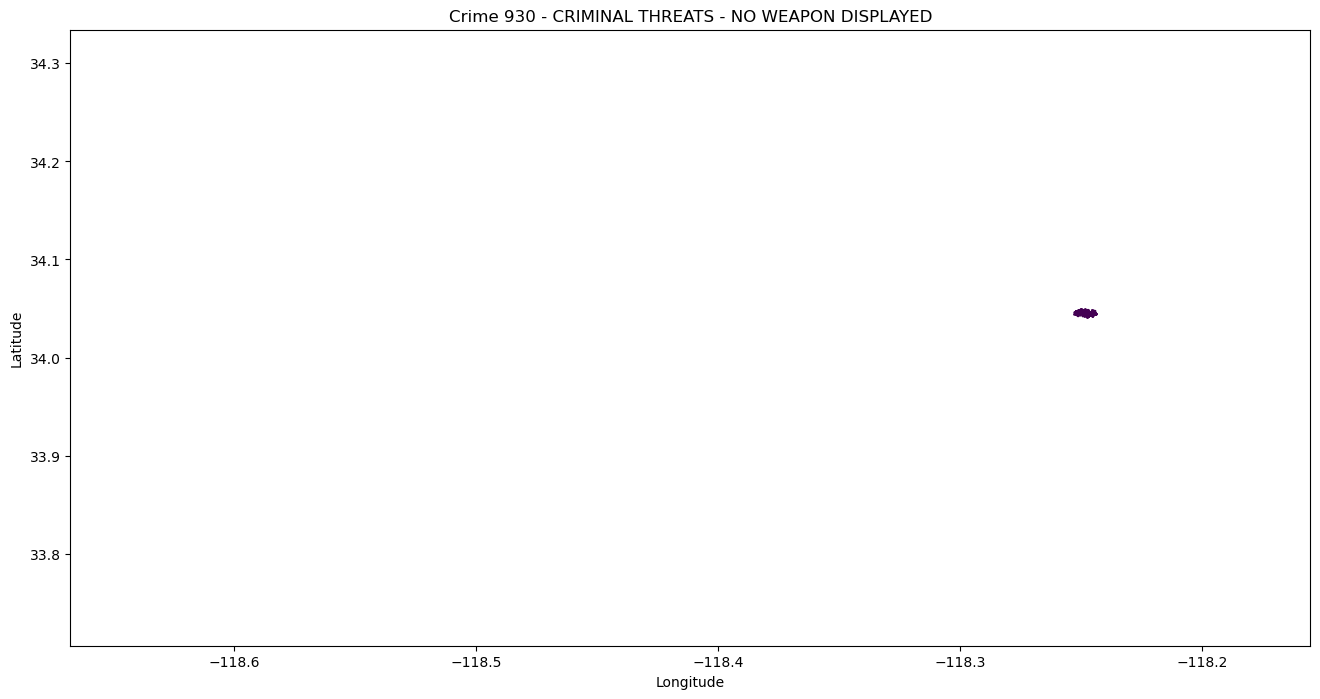

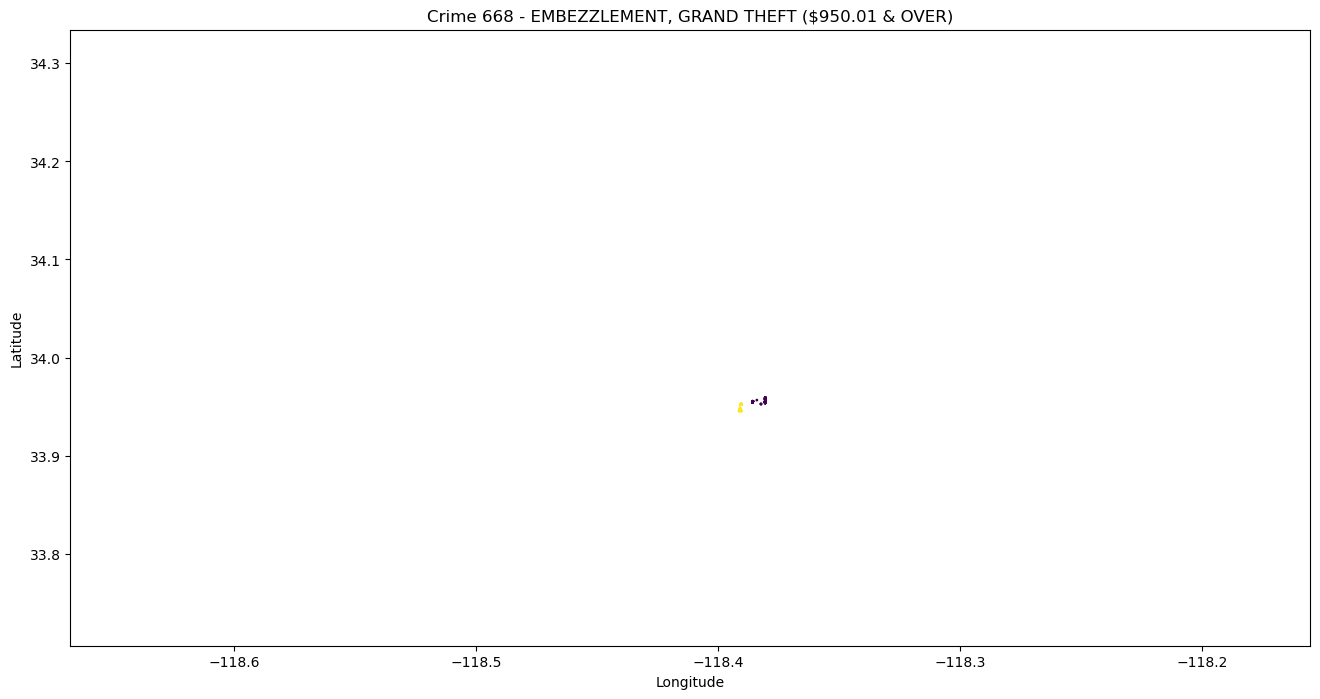

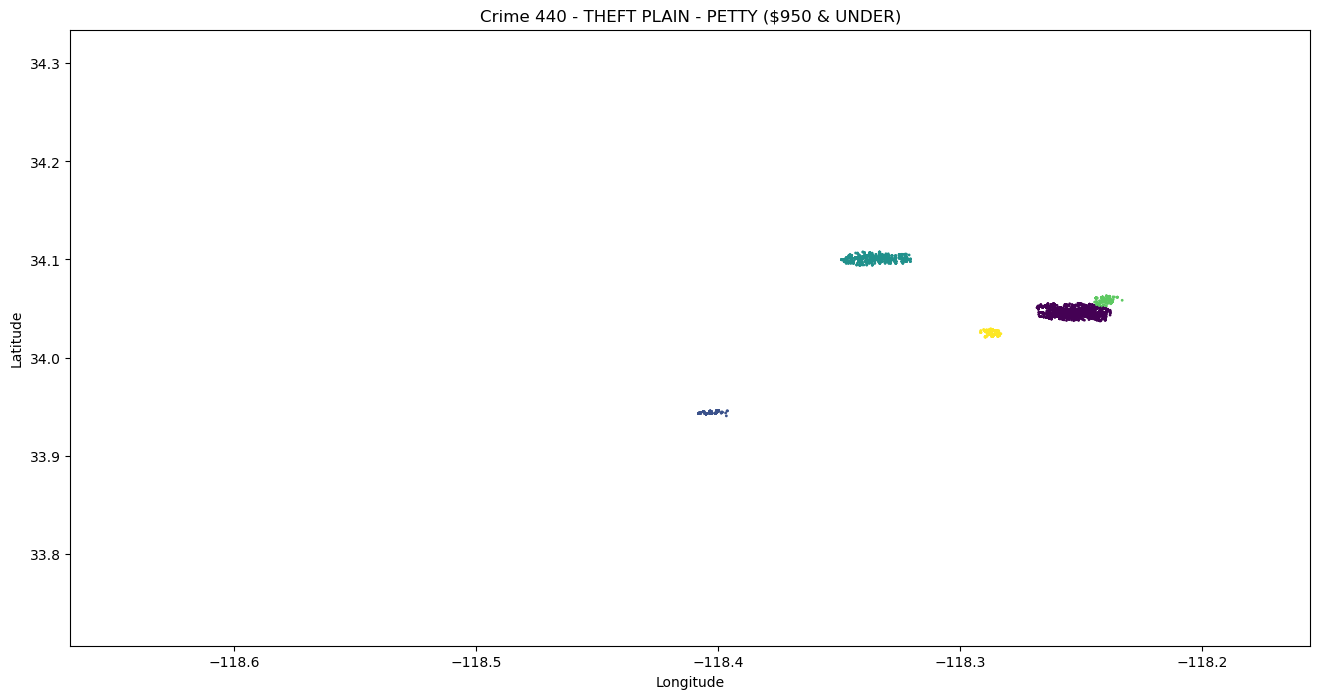

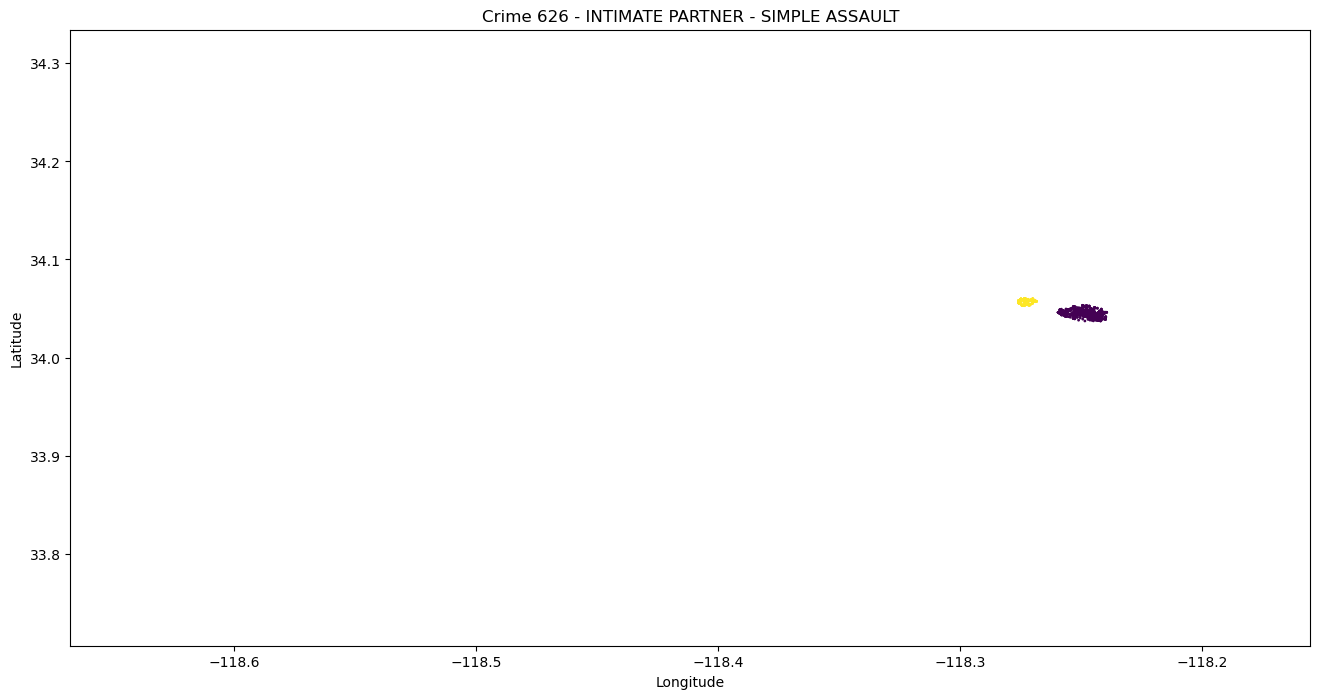

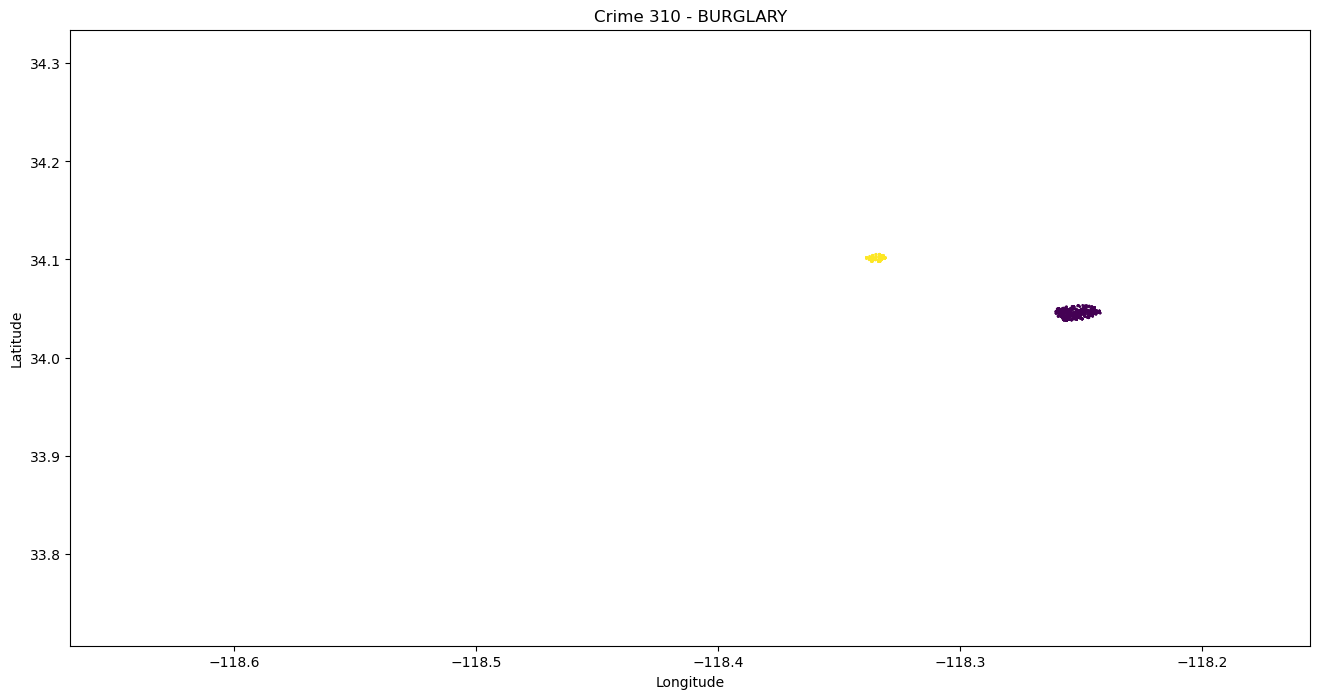

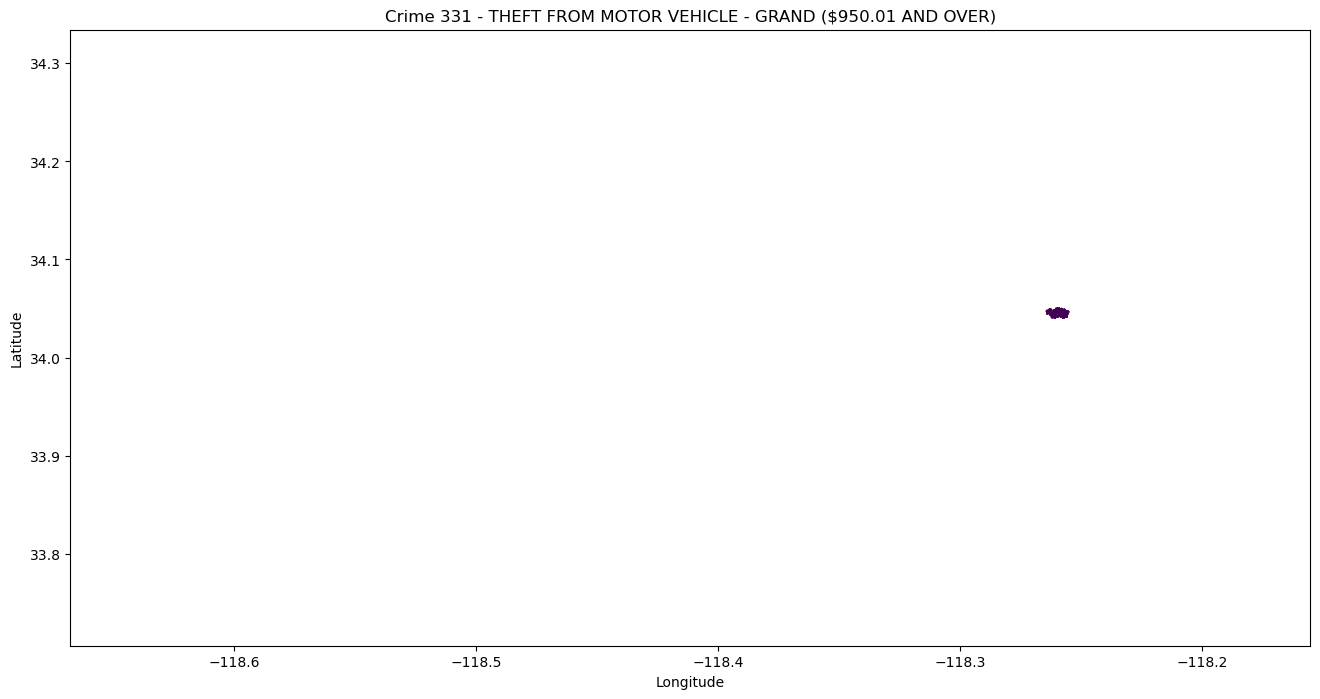

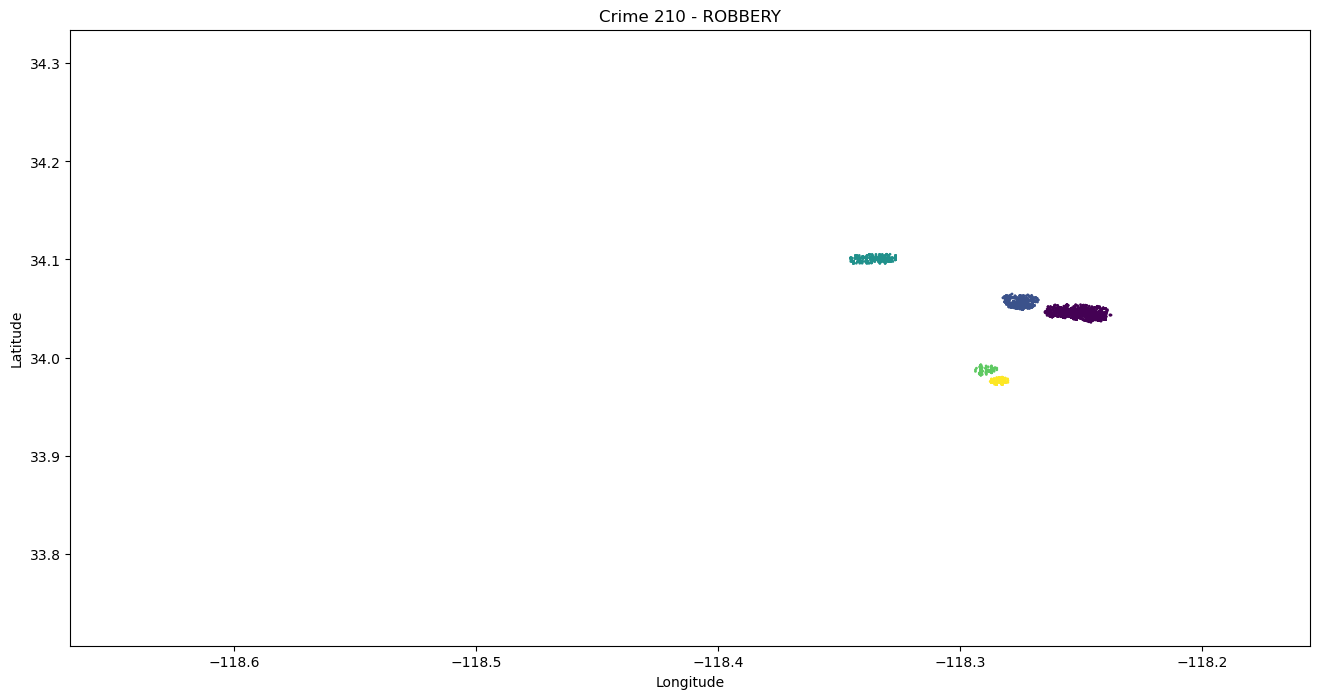

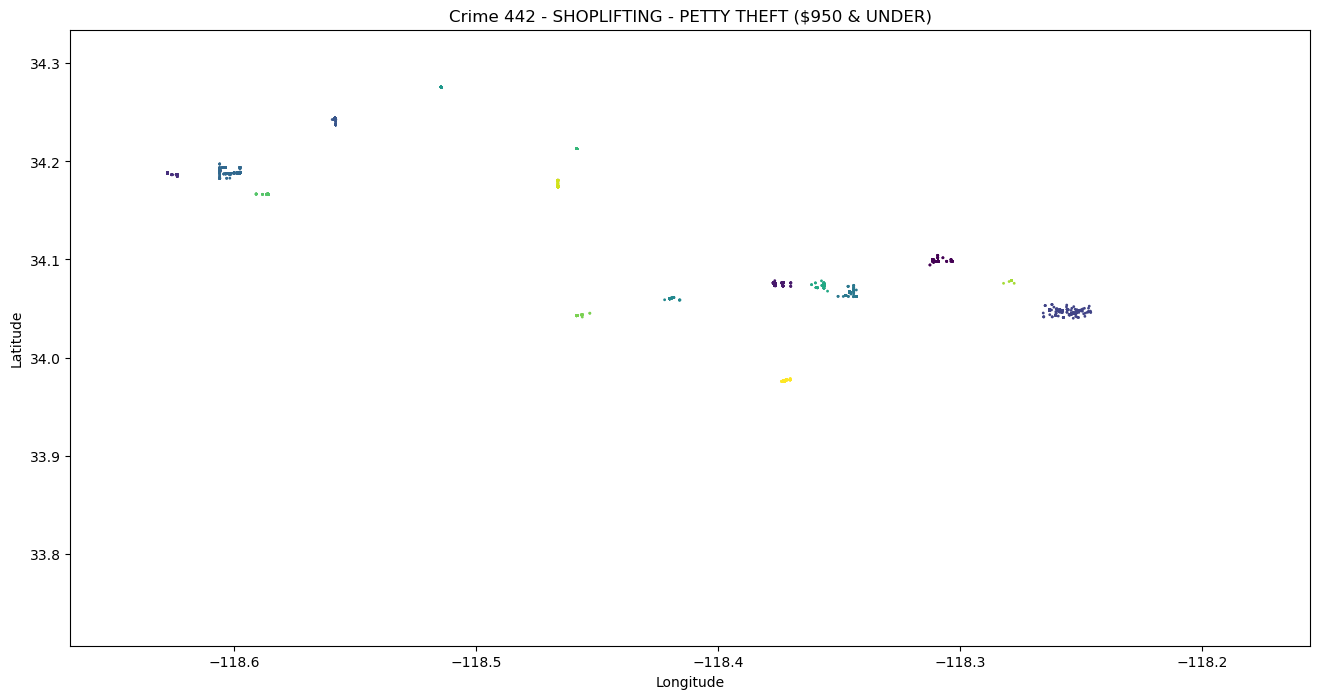

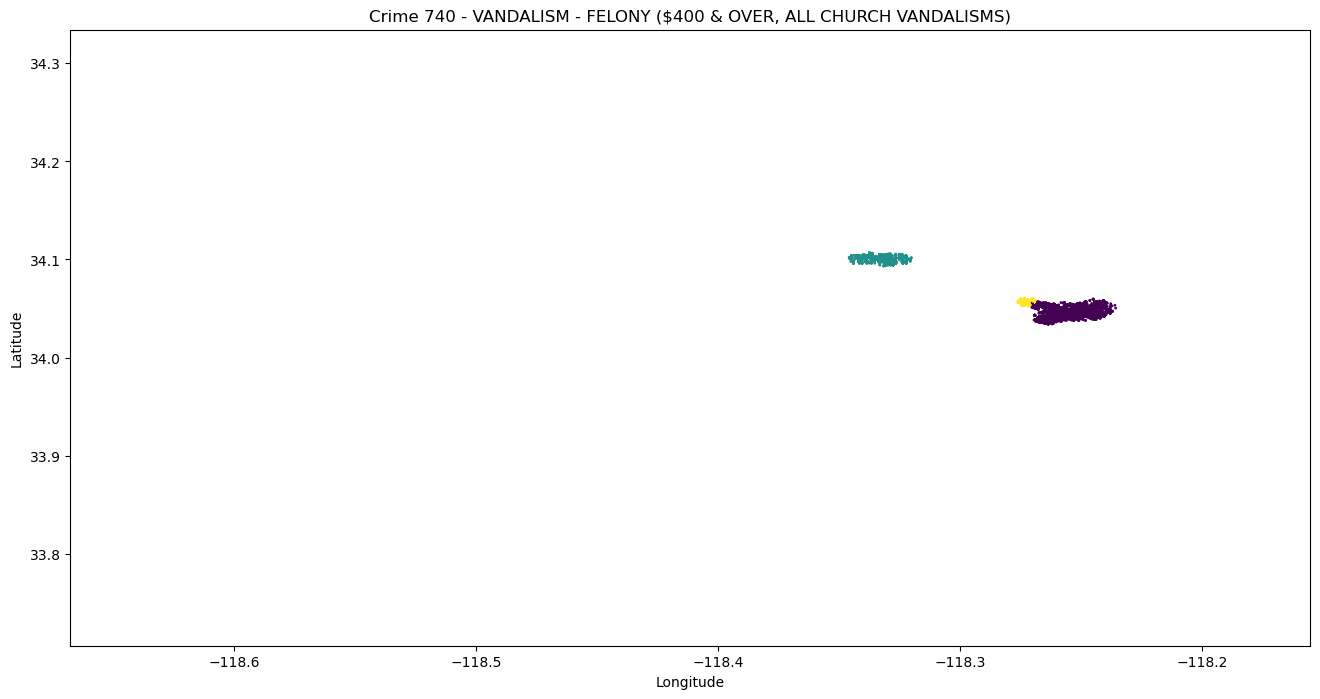

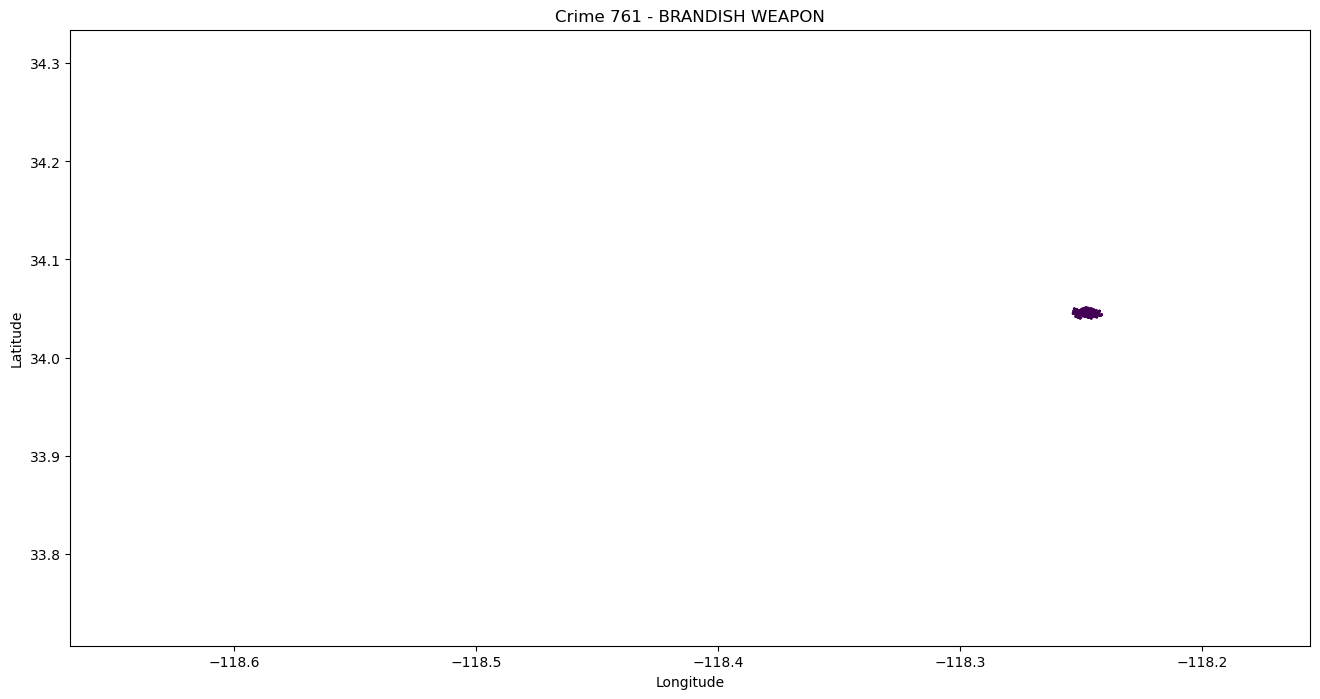

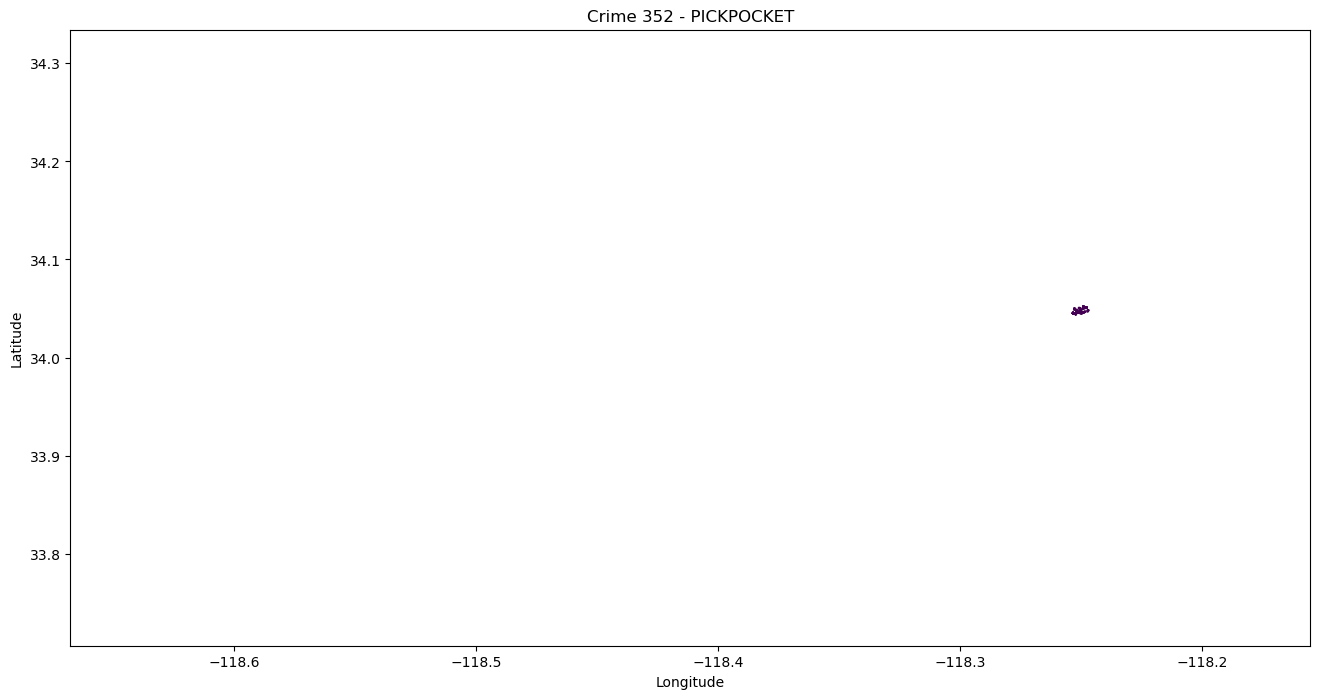

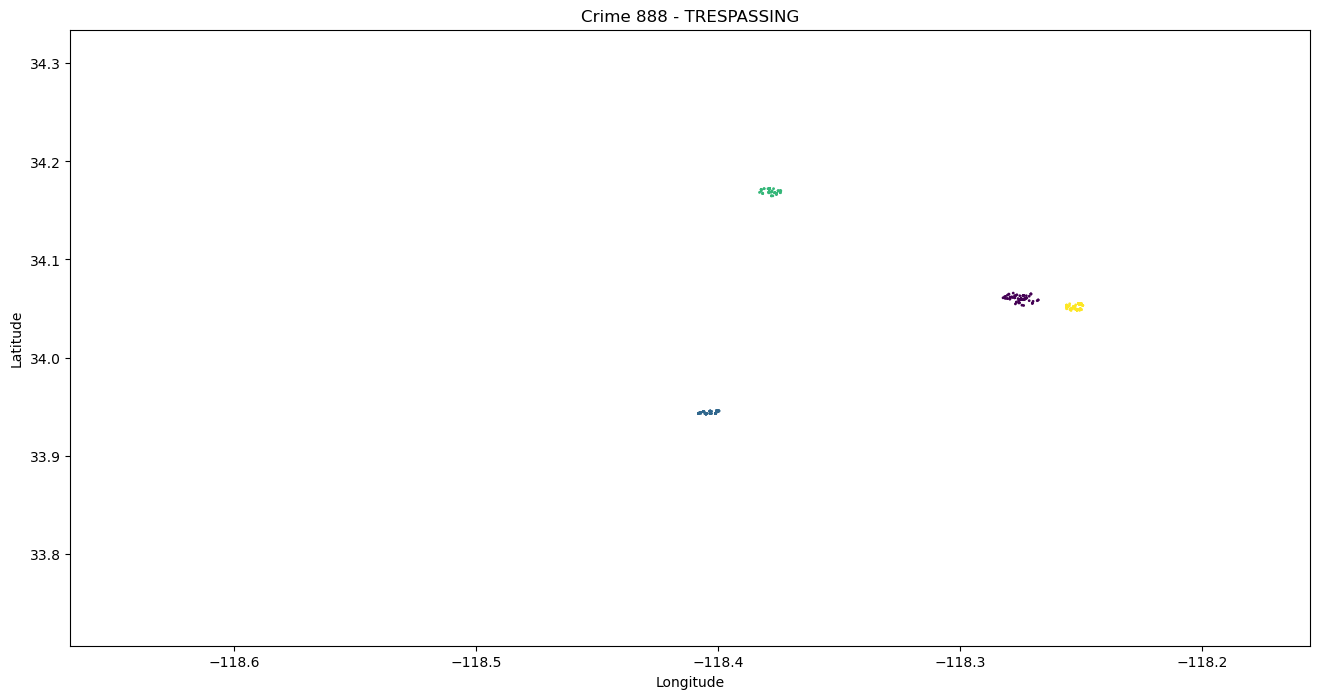

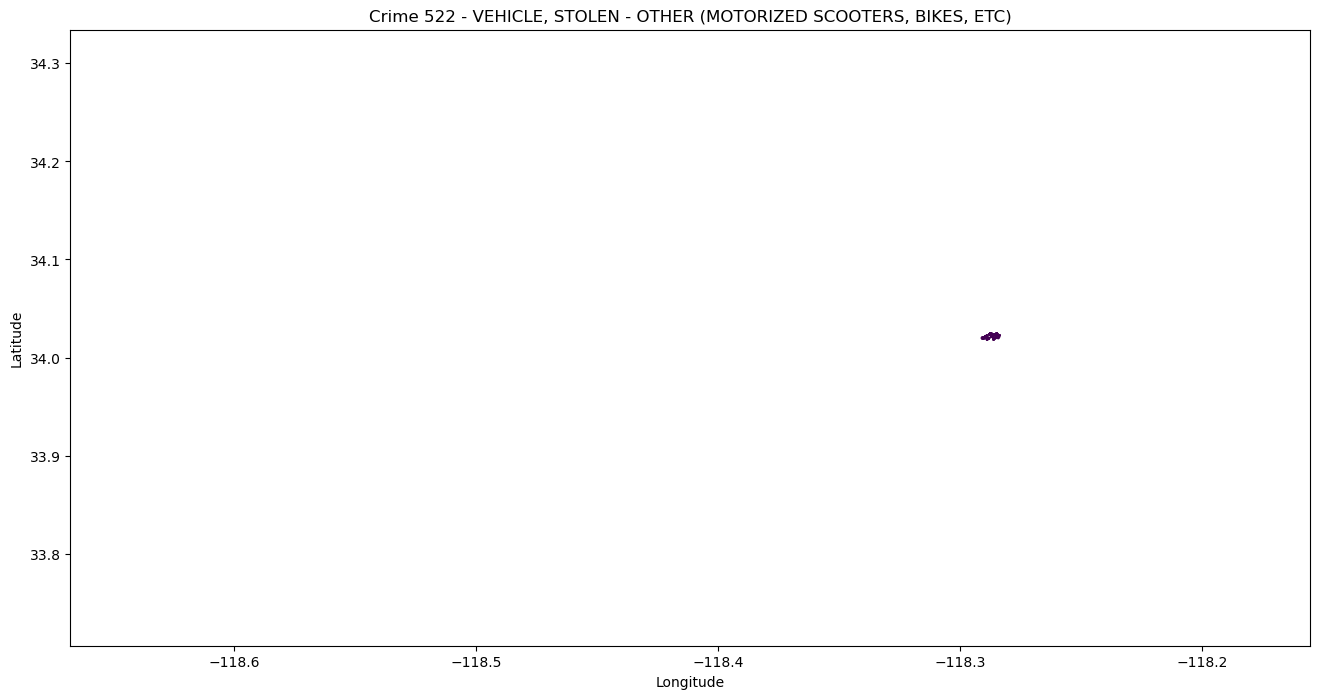

In [6]:
crimes = data["Crm Cd"].unique()

# drop values that are not in LA area (outside 34	-118)
data_locations = data_locations[(data_locations["LAT"] > 33) & (data_locations["LAT"] < 35)]
data_locations = data_locations[(data_locations["LON"] < -117) & (data_locations["LON"] > -119)]

min_lat, max_lat = data_locations["LAT"].min(), data_locations["LAT"].max()
min_lon, max_lon = data_locations["LON"].min(), data_locations["LON"].max()

# create list with columns crime, cluster, center
data_centers = []

# for each crime, cluster densed areas
for crime in crimes:
    data_locations_crime = data_locations.loc[data["Crm Cd"] == crime]

    if len(data_locations_crime) <= 100:
        continue

    clustering = DBSCAN(eps=0.004, min_samples=250, n_jobs=-1).fit(data_locations_crime[["LAT", "LON"]])

    unique_labels = len(np.unique(clustering.labels_))
    if unique_labels <= 1:
        continue

    data_locations_crime["cluster"] = clustering.labels_
    data_locations_crime = data_locations_crime.loc[data_locations_crime["cluster"] != -1]

    crime_desc = data.loc[data["Crm Cd"] == crime].iloc[0]["Crm Cd Desc"]

    # for each cluster calculate the center and store it
    for cluster in data_locations_crime["cluster"].unique():
        data_cluster = data_locations_crime.loc[data_locations_crime["cluster"] == cluster]

        # center is average of all points in cluster
        center = (data_cluster["LAT"].mean(), data_cluster["LON"].mean())

        data_centers.append((crime, cluster, center))

    plt.figure(figsize=(16, 8))
    plt.scatter(data_locations_crime["LON"], data_locations_crime["LAT"], c=data_locations_crime["cluster"], s=1)

    # limits
    plt.xlim(min_lon, max_lon)
    plt.ylim(min_lat, max_lat)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Crime {crime} - {crime_desc}")

    plt.show()

In [7]:
# convert data_centers to dataframe

data_centers = pd.DataFrame(data_centers, columns=["Crm Cd", "cluster", "center"])

data_centers

Crm Cd  cluster                                     center
0      510       13  (33.948872862453534, -118.39143568773234)
1      510        1   (34.04603560913705, -118.26094921319797)
2      510        4   (34.06566636125655, -118.29817787958115)
3      510        0   (33.967826265389874, -118.2842002735978)
4      510       12   (34.06201418685121, -118.26009307958476)
..     ...      ...                                        ...
80     888        1  (33.944341416893735, -118.40329482288828)
81     888        0   (34.05967242424243, -118.27500484848484)
82     888        3          (34.0511612, -118.25188759999999)
83     888        2   (34.17039214285714, -118.37810821428572)
84     522        0    (34.02184822134388, -118.2872671936759)

[85 rows x 3 columns]

In [8]:
# maps common

import folium


popup_name_neighborhoods = folium.GeoJsonPopup(fields=["name"], labels=True)
geojson_neighborhoods = folium.GeoJson(
    "la_neighborhoods.geojson",
    style_function=lambda feature: {
        "fillColor": "#abcbff",
        "color": "black",
        "weight": 1,
        "dashArray": "3, 3",
    },
    highlight_function=lambda x: {"fillColor": "#458cff"},
    smooth_factor=2.0,
    name="LA neighborhoods",
    popup=popup_name_neighborhoods,
    zoom_on_click=True
)

In [9]:
# plot all data_centers as markers (crime + cluster num)

map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")
geojson_neighborhoods.add_to(map)

for index, row in data_centers.iterrows():
    folium.Marker(
        location=[row["center"][0], row["center"][1]],
        popup=f"Crime description: {data.loc[data['Crm Cd'] == row['Crm Cd']].iloc[0]['Crm Cd Desc']}<br>Cluster: {row['cluster']}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(map)

map




In [10]:
# cluster data_centers and find points with most density of crimes

clustering = DBSCAN(eps=0.02, min_samples=1, n_jobs=-1).fit(data_centers["center"].tolist())

data_centers["global_cluster"] = clustering.labels_

# calculate center of global clusters

global_centers = []

# all unique without -1
for cluster in data_centers["global_cluster"].unique():
    if cluster == -1:
        continue

    data_cluster = data_centers.loc[data_centers["global_cluster"] == cluster]

    center = (data_cluster["center"].apply(lambda x: x[0]).mean(), data_cluster["center"].apply(lambda x: x[1]).mean())

    sum_crimes = len(data_cluster)

    global_centers.append((cluster, center, sum_crimes))

# plot all global data centers as markers

map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")
geojson_neighborhoods.add_to(map)

for index, row, n_crimes in global_centers:
    folium.Marker(
        location=[row[0], row[1]],
        popup=f"Global cluster: {index} | Crimes: {n_crimes}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(map)

map

In [11]:
# convert global_centers to dataframe

global_centers = pd.DataFrame(global_centers, columns=["global_cluster", "center", "n_crimes"])

global_centers

global_cluster                                     center  n_crimes
0                0   (33.94789583033073, -118.39524906498042)         6
1                1   (34.05377527233995, -118.26352678277006)        34
2                2   (33.98250567824204, -118.28796826429786)         8
3                3  (33.945953962264156, -118.27138452830188)         1
4                4  (34.023756524020506, -118.27519667682208)         4
5                5     (34.1008495952719, -118.3339410821425)         9
6                6    (34.16809176837116, -118.3759126814881)         3
7                7    (34.1899980815011, -118.60335846172364)         2
8                8   (34.01599308252427, -118.34834769417476)         1
9                9  (33.936769473684215, -118.25276666666664)         1
10              10    (33.9908620013977, -118.47543129971898)         2
11              11  (34.099397277946736, -118.30817168674697)         2
12              12   (34.07185420235999, -118.35903507930328)         3
13              13   (34.18799550000001, -118.62688375000002)         1
14              14   (34.24320815850817, -118.55826759906759)         1
15              15   (34.17485719844357, -118.46611906614788)         1
16              16   (34.06092030905078, -118.41860971302428)         1
17              17             (34.27570000000001, -118.5144)         1
18              18  (34.042808104886774, -118.45817723480334)         1
19              19             (34.2131, -118.45840000000001)         1
20              20   (34.16647303370787, -118.58618576779025)         1
21              21   (33.97654797979798, -118.37235429292927)         1

In [12]:
# sort by number of crimes

global_centers = global_centers.sort_values(by="n_crimes", ascending=False)

global_centers

global_cluster                                     center  n_crimes
1                1   (34.05377527233995, -118.26352678277006)        34
5                5     (34.1008495952719, -118.3339410821425)         9
2                2   (33.98250567824204, -118.28796826429786)         8
0                0   (33.94789583033073, -118.39524906498042)         6
4                4  (34.023756524020506, -118.27519667682208)         4
12              12   (34.07185420235999, -118.35903507930328)         3
6                6    (34.16809176837116, -118.3759126814881)         3
10              10    (33.9908620013977, -118.47543129971898)         2
11              11  (34.099397277946736, -118.30817168674697)         2
7                7    (34.1899980815011, -118.60335846172364)         2
9                9  (33.936769473684215, -118.25276666666664)         1
8                8   (34.01599308252427, -118.34834769417476)         1
3                3  (33.945953962264156, -118.27138452830188)         1
13              13   (34.18799550000001, -118.62688375000002)         1
14              14   (34.24320815850817, -118.55826759906759)         1
15              15   (34.17485719844357, -118.46611906614788)         1
16              16   (34.06092030905078, -118.41860971302428)         1
17              17             (34.27570000000001, -118.5144)         1
18              18  (34.042808104886774, -118.45817723480334)         1
19              19             (34.2131, -118.45840000000001)         1
20              20   (34.16647303370787, -118.58618576779025)         1
21              21   (33.97654797979798, -118.37235429292927)         1

In [13]:
# get top 1 cluster's center and find all crimes within 0.03 radius

top_cluster = global_centers.iloc[0]
top_cluster_center = top_cluster["center"]

# filter crimes from data that LAT LON points are within 0.03 radius from top_cluster_center
top_cluster_crimes = data.loc[(data["LAT"] - top_cluster_center[0])**2 + (data["LON"] - top_cluster_center[1])**2 < 0.03**2]

print(len(top_cluster_crimes))
print(f"{(len(top_cluster_crimes) / len(data)) * 100}% of all crimes")

111420
12.747306556591202% of all crimes


In [14]:
# plot cluster on map

map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")
geojson_neighborhoods.add_to(map)

# center of cluster
folium.Marker(
    location=[top_cluster_center[0], top_cluster_center[1]],
    popup=f"Global cluster: {top_cluster['global_cluster']} | Crimes: {top_cluster['n_crimes']}",
    icon=folium.Icon(color="red", icon="info-sign")
).add_to(map)

# circular area
folium.Circle(
    location=[top_cluster_center[0], top_cluster_center[1]],
    radius=0.03 * 100000,
    color="red",
    fill=True,
    fill_color="red"
).add_to(map)

map

In [15]:
# count crimes count and sort them

top_cluster_crimes_count = top_cluster_crimes.groupby("Crm Cd").size().reset_index(name="count")
top_cluster_crimes_count = top_cluster_crimes_count.sort_values(by="count", ascending=False)

top_cluster_crimes_count

Crm Cd  count
53      624  11517
14      330  10663
48      510   9611
5       230   7710
71      740   7234
..      ...    ...
110     931      1
47      487      1
46      485      1
44      475      1
39      451      1

[122 rows x 2 columns]

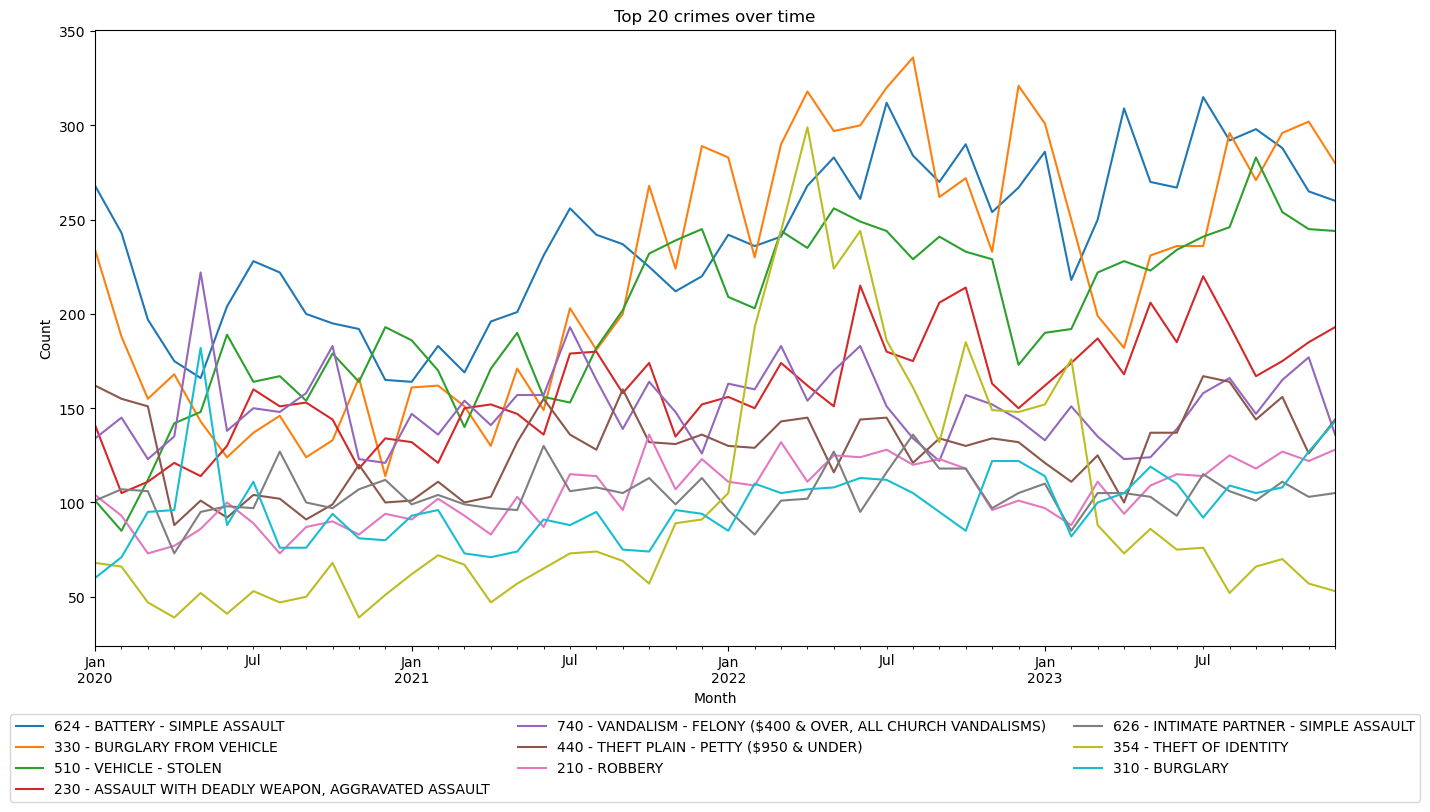

In [16]:
# plot with top 20 crimes over time by month

top_cluster_crimes["month"] = top_cluster_crimes["DATE OCC"].dt.to_period("M")

# crimes that are in top 20 crimes count
top_crimes = top_cluster_crimes_count["Crm Cd"].head(10).tolist()

# crimes from top_cluster_crimes
top_cluster_crimes = top_cluster_crimes.loc[top_cluster_crimes["Crm Cd"].isin(top_crimes)]


fig, ax = plt.subplots(figsize=(16, 8))
colors = plt.cm.tab10.colors

for crime in top_crimes:
    data_crime = top_cluster_crimes.loc[top_cluster_crimes["Crm Cd"] == crime].groupby("month").size().reset_index(name="count")
    crime_desc = data.loc[data["Crm Cd"] == crime].iloc[0]["Crm Cd Desc"]

    data_crime.plot(x="month", y="count", ax=ax, label=f"{crime} - {crime_desc}")



plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Top 20 crimes over time")

for i, color in enumerate(colors):
    plt.gca().get_lines()[i].set_color(color)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.show()


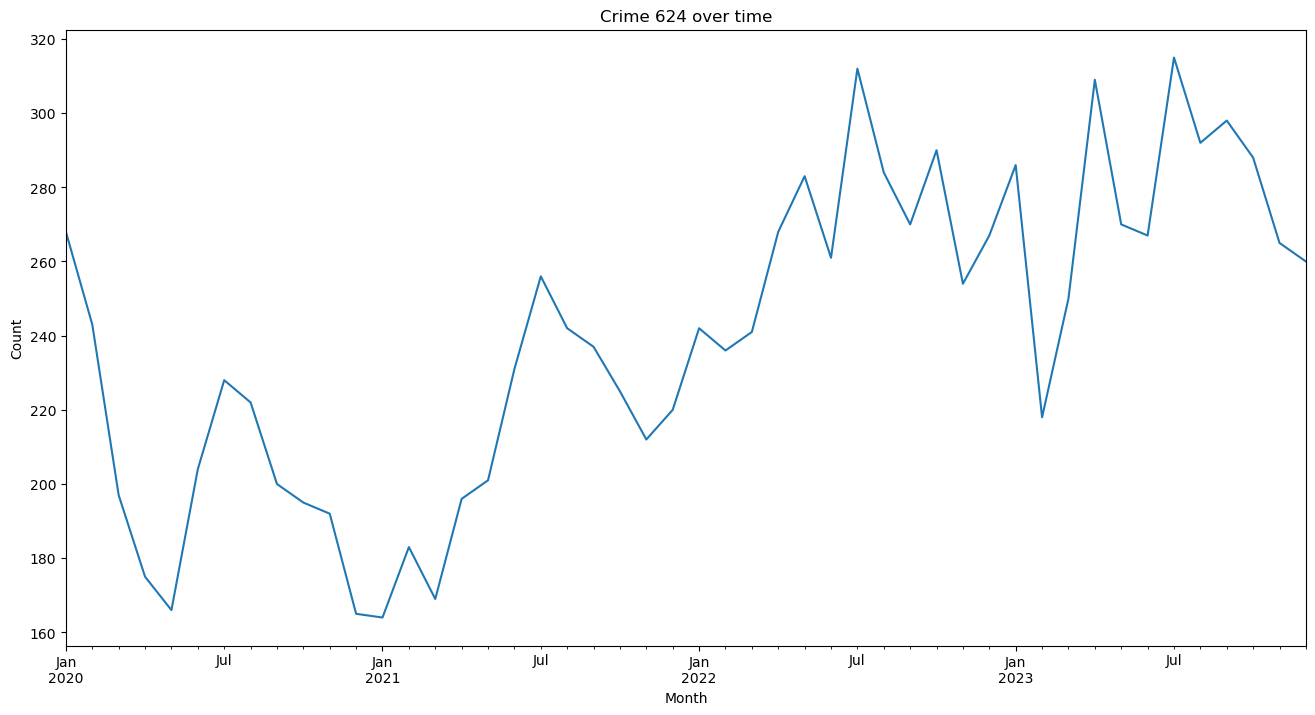

In [20]:
# plot crime 624 only

crime_624 = top_cluster_crimes.loc[top_cluster_crimes["Crm Cd"] == 624]

fig, ax = plt.subplots(figsize=(16, 8))

crime_624.groupby("month").size().plot(ax=ax)

plt.xlabel("Month")
plt.ylabel("Count")

plt.title("Crime 624 over time")

plt.show()

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# create train data before 01-01-2023
train_crime = crime_624.loc[crime_624["DATE OCC"] < "2023-01-01"].groupby("month").size()

# create test data after 01-01-2023
test_crime = crime_624.loc[crime_624["DATE OCC"] >= "2023-01-01"].groupby("month").size()


In [25]:
train_crime

month
2020-01    268
2020-02    243
2020-03    197
2020-04    175
2020-05    166
2020-06    204
2020-07    228
2020-08    222
2020-09    200
2020-10    195
2020-11    192
2020-12    165
2021-01    164
2021-02    183
2021-03    169
2021-04    196
2021-05    201
2021-06    231
2021-07    256
2021-08    242
2021-09    237
2021-10    225
2021-11    212
2021-12    220
2022-01    242
2022-02    236
2022-03    241
2022-04    268
2022-05    283
2022-06    261
2022-07    312
2022-08    284
2022-09    270
2022-10    290
2022-11    254
2022-12    267
Freq: M, dtype: int64

In [63]:
# create SARIMAX model ARMA model

ARMAmodel = SARIMAX(train_crime, order = (5, 4, 2), seasonal_order=(1,0,5,12))
ARMAmodel = ARMAmodel.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.16673D+00    |proj g|=  1.28987D+00


 This problem is unconstrained.



At iterate    5    f=  4.31252D+00    |proj g|=  6.96239D-02

At iterate   10    f=  4.29601D+00    |proj g|=  1.01751D-02

At iterate   15    f=  4.26788D+00    |proj g|=  2.91933D-02

At iterate   20    f=  4.25023D+00    |proj g|=  5.56673D-02

At iterate   25    f=  4.23339D+00    |proj g|=  1.48372D-02

At iterate   30    f=  4.22986D+00    |proj g|=  7.86929D-03

At iterate   35    f=  4.22753D+00    |proj g|=  7.33667D-03

At iterate   40    f=  4.22702D+00    |proj g|=  2.56245D-03

At iterate   45    f=  4.22677D+00    |proj g|=  1.31253D-03

At iterate   50    f=  4.22673D+00    |proj g|=  9.45893D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/kappa/.miniforge3/envs/science/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
y_pred = ARMAmodel.get_forecast(len(test_crime.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_crime.index
y_pred_out = y_pred_df["Predictions"] 


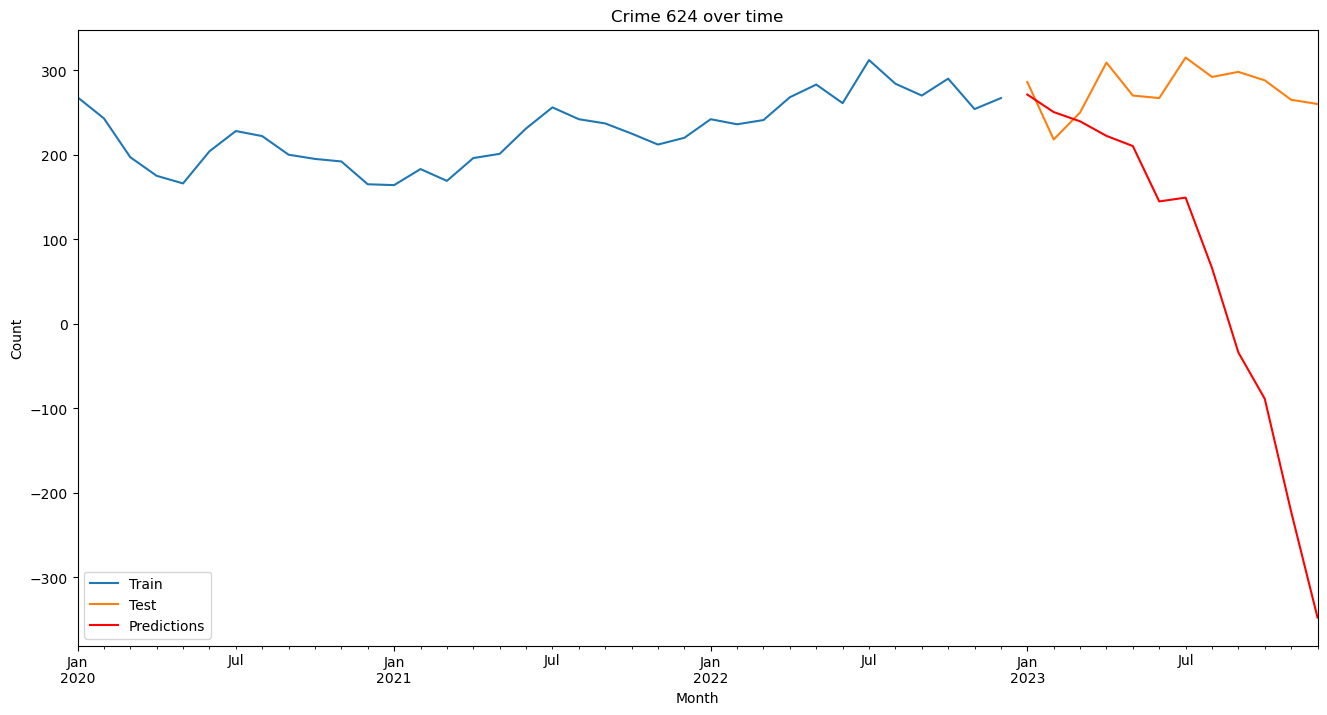

In [65]:
# plot predicitons

fig, ax = plt.subplots(figsize=(16, 8))

train_crime.plot(ax=ax, label="Train")
test_crime.plot(ax=ax, label="Test")

y_pred_out.plot(ax=ax, label="Predictions", color="red")

plt.xlabel("Month")
plt.ylabel("Count")

plt.title("Crime 624 over time")

plt.legend()

plt.show()